In [1]:
import numpy as np
import math

In [2]:
def dcg_of_item(actual_location, desired_location, length):
    distance = np.abs(actual_location - desired_location)
    score = length - distance
    # the closer you are the higher the score
    denominator = np.log2(actual_location+1)
    return score/denominator
    
    

In [3]:
def calculate_score_of_ranking(desired_ranking, actual_ranking):
    score_sum = 0
    for i in range(len(desired_ranking)):
        item = actual_ranking[i] # this is the item that was in the ith place
        desired_rank_of_item = desired_ranking.index(item)+1
        score = dcg_of_item(i+1, desired_rank_of_item, len(desired_ranking))
        score_sum += score
    return score_sum

In [59]:
def calculate_ideal_score(size):
    ideal_list = list(range(size))
    return calculate_score_of_ranking(ideal_list,ideal_list)

In [4]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import seaborn as sns
from ExplainableMaximumLikelihoodCalculator import ExplainableMaximumLikelihoodCalculator
import pysam
from Bio import SeqIO, Seq, SeqRecord, pairwise2
from Bio.pairwise2 import format_alignment
from LoadDataUtils import getListOfReadsFromBamFile, getListOfReadsFromFastaFile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
import shap
from scipy.stats import chisquare
from scipy.special import rel_entr
fileNameSapiens =  "data/simulatedData/human_chinese_AF346973_500samples.fas" #File that contains 500 reads from homo sapiens
fileNameNeanderthals =  "data/simulatedData/Neanderthal_Goyet_KX198085_500samples.fas" #File that contains 500 reads from neanderthal
fileNameDenisovans =  "data/simulatedData/denisova_kx663333_500samples.fas" #File that contains 500 reads from denisovan
neanderthals_500_generated = getListOfReadsFromFastaFile(fileNameNeanderthals)
sapiens_500_generated = getListOfReadsFromFastaFile(fileNameSapiens)
denisovan_500_samples = getListOfReadsFromFastaFile(fileNameDenisovans)
path_to_frequencies_table = "data/substitution_matrix.tsv"

2023-08-12 15:38:27.164872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-12 15:38:27.565089: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-12 15:38:27.630938: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-12 15:38:28.465015: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [5]:
sapiens_reference_file_names = [
                    "data/reference_files/human_AF346981_French.fa",
                     "data/reference_files/human_AY195760_Korea.fa",
                      "data/reference_files/human_AY882416_Ethiopia.fa",
                      "data/reference_files/human_AY963586_Italian.fa",
                      "data/reference_files/human_AY195781_Caucasian.fa",
                      "data/reference_files/human_AY195757_Iraqi-Israeli.fa",
                      "data/reference_files/human_AY195749_NativeAmerican.fa"]
neanderthals_reference_file_names = [
                            "data/reference_files/neanderthal_mezmaiskaya1_FM865411.fa",
                           "data/reference_files/Neanderthal_Altai_KC879692.fa",
                           "data/reference_files/Neanderthal_Denisova11_full_mtDNA_KU131206.fa",
                           "data/reference_files/Neanderthal_Spy_94a_MG025538.fa",
                            "data/reference_files/Neanderthal_Vindija33.16_AM948965.fa",
                            "data/reference_files/Neanderthal_Vindija33.19_KJ533545.fa"]
denisovan_reference_file_names = [  
                        "data/reference_files/Denisova_MT576653.1.fa",
                        "data/reference_files/Denisova_MT576652.1.fa",
                        "data/reference_files/Denisova_4_FR695060.fa",
                        "data/reference_files/Denisova_8_KT780370.fa",
                        "data/reference_files/Denisova_manual_phalanx_NC_013993.fa",
                        "data/reference_files/Denisova_MT576651.1.fa"]

In [6]:
def generate_sample(sap, nean, den):
    list_before =  list(np.random.choice(sapiens_500_generated, sap)) + list(np.random.choice(neanderthals_500_generated, nean)) + list(np.random.choice(denisovan_500_samples, den))
    l = []
    for i in list_before:
        l.append(str(i))
    return l

In [7]:
from itertools import combinations

def find_all_subsets(group):
    all_subsets = []
    n = len(group)
    
    for r in range(n + 1):
        subsets_r = combinations(group, r)
        all_subsets.extend(list(subsets_r))
        
    return all_subsets

In [8]:
def calculate_shapley_values_for_datum(data_point, length_of_data, ml_calculator):
    indexes_without_datum = [i for i in range(length_of_data) if i != data_point]
    all_subsets = find_all_subsets(indexes_without_datum)
    sum_over_all_subsets = 0 
    for G in all_subsets:
        g_with = [i for i in G]
        g_with.append(data_point)
        with_datum = ml_calculator.calc_maximum_likelihood_on_subset(subset_of_indexes=g_with).values[0]
        without_datum = ml_calculator.calc_maximum_likelihood_on_subset(subset_of_indexes=G).values[0]
        with_minus_without = with_datum - without_datum
        multiplier = np.math.factorial(len(G)) * np.math.factorial(length_of_data - len(G) - 1)
        value_for_sum = with_minus_without * multiplier 
        sum_over_all_subsets += value_for_sum
    shapleys = sum_over_all_subsets / np.math.factorial(length_of_data)
    return  shapleys

In [10]:
def calculateRankingResultsForLabel(label, ground_truth_shapleys, shaps, a_s_d, shapley_values_monte_carlo):
    ranking_results = []
    ground_truth_shapley_label = [i[label] for i in ground_truth_shapleys]
    ground_shapley_label_with_index = []
    for i in range(len(ground_truth_shapley_label)):
        ground_shapley_label_with_index.append((ground_truth_shapley_label[i], i))
    ground_shapley_label_with_index_sorted = sorted(ground_shapley_label_with_index, key=lambda a:a[0], reverse=True)
    only_indexes_sorted = [i[1] for i in ground_shapley_label_with_index_sorted]

    shaps_label = shaps[label][0]
    shaps_with_index = []
    for i in range(len(shaps_label)):
        shaps_with_index.append((shaps_label[i], i))
    shap_label_with_index_sorted = sorted(shaps_with_index, key=lambda a:a[0], reverse=True)
    only_indexes_sorted_shap = [i[1] for i in shap_label_with_index_sorted]
    ranking_result_shap = calculate_score_of_ranking(only_indexes_sorted, only_indexes_sorted_shap)

    a_s_d_label = [i[label] for i in a_s_d]
    a_s_d_index = []
    for i in range(len(a_s_d_label)):
        a_s_d_index.append((a_s_d_label[i], i))
    a_s_d_with_index_sorted = sorted(a_s_d_index, key=lambda a:a[0], reverse=True)
    only_indexes_sorted_a_s_d = [i[1] for i in a_s_d_with_index_sorted]
    ranking_result_a_s_d = calculate_score_of_ranking(only_indexes_sorted, only_indexes_sorted_a_s_d)

    monte_carlo_label = shapley_values_monte_carlo[label][0]
    monte_carlo_label_with_index = []
    for i in range(len(monte_carlo_label)):
        monte_carlo_label_with_index.append((monte_carlo_label[i], i))
    monte_carlo_label_with_index_sorted = sorted(monte_carlo_label_with_index, key=lambda a:a[0], reverse=True)
    monte_carlo_only_indexes_sorted = [i[1] for i in monte_carlo_label_with_index_sorted]
    ranking_result_monte_carlo = calculate_score_of_ranking(only_indexes_sorted, monte_carlo_only_indexes_sorted)

    ranking_results.append((ranking_result_shap, ranking_result_a_s_d, ranking_result_monte_carlo))
    return ranking_results


In [54]:
def calculateRankingForAllALgorithms(ml_calculator, number_of_samples, ground_truth_shapleys):
    
    
    shaps = ml_calculator.calculate_shapley_values(number_of_samples)
    a_s_d = ml_calculator.get_A_s_d_values()
    shapley_values_monte_carlo = ml_calculator.estimate_shapley_values(number_of_samples_per_read = number_of_samples)
    results = []
    for i in range(3):
        result = calculateRankingResultsForLabel(i, ground_truth_shapleys, shaps, a_s_d, shapley_values_monte_carlo)
        results.append(result)

    results_shap = np.mean([i[0][0] for i in results])
    results_a_s_d = np.mean([i[0][1] for i in results])
    results_monte_carlo = np.mean([i[0][2] for i in results])


    return((results_shap, results_a_s_d, results_monte_carlo))



In [56]:
data = generate_sample(5,4,3)
maximum_likelihood_calculator_d_1 = ExplainableMaximumLikelihoodCalculator(data,
                                                    ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                    ref_sapien_file_names=sapiens_reference_file_names,
                                                    ref_denisovan_file_names=denisovan_reference_file_names,
                                                    path_to_substitution_matrix=path_to_frequencies_table,
                                                    number_of_jobs=-1)
ground_truth_shapleys = []
for i in range(len(data)):
    print(i)
    ground_truth_shapleys.append(calculate_shapley_values_for_datum(i,len(data),maximum_likelihood_calculator_d_1))



Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  12
start working on read number 0
0
1
2
3
4
5
6
7
8
9
10
11


In [62]:
sample_sizes = [1,5,10,20,30,50,100,200,400,600,800,1000]
all_scores = []
for size in sample_sizes:
    print(size)
    res = calculateRankingForAllALgorithms(maximum_likelihood_calculator_d_1, size, ground_truth_shapleys)
    ideal_score = calculate_ideal_score(len(data))
    all_scores.append((size, [i/ideal_score for i in res]))
    print(all_scores)

1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1
[(1, [0.6796071650077011, 0.9258408981735105, 0.8450310989966305])]
5
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
[(1, [0.6796071650077011, 0.9258408981735105, 0.8450310989966305]), (5, [0.6901382997563645, 0.9258408981735105, 0.9067386748217748])]
10
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
[(1, [0.6796071650077011, 0.9258408981735105, 0.8450310989966305]), (5, [0.6901382997563645, 0.9258408981735105, 0.9067386748217748]), (10, [0.7230868297249391, 0.9258408981735105, 0.9183213348322976])]
20
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
[(1, [0.6796071650077011, 0.9258408981735105, 0.8450310989966305]), (5, [0.6901382997563645, 0.9258408981735105, 0.9067386748217748]), (10, [0.7230868297249391, 0.9258408981735105, 0.9183213348322976]), (20, [0.7721475641844133, 0.9258408981735105, 0.9455763392013109])]
30
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
30
[(1, [0.6796071650077011, 0.9258408981735105, 0.8450310989966305]), (5, [0.6901382997563645, 0.9258408981735105, 0.9067386748217748]), (10, [0.7230868297249391, 0.9258408981735105, 0.9183213348322976]), (20, [0.7721475641844133, 0.9258408981735105, 0.9455763392013109]), (30, [0.8860272104740144, 0.9258408981735105, 0.9254985770941598])]
50
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
[(1, [0.6796071650077011, 0.9258408981735105, 0.8450310989966305]), (5, [0.6901382997563645, 0.9258408981735105, 0.9067386748217748]), (10, [0.7230868297249391, 0.9258408981735105, 0.9183213348322976]), (20, [0.7721475641844133, 0.9258408981735105, 0.9455763392013109]), (30, [0.8860272104740144, 0.9258408981735105, 0.9254985770941598]), (50, [0.8688864780385712, 0.9258408981735105, 0.9400016471892979])]
100
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
[(1, [0.6796071650077011, 0.9258408981735105, 0.8450310989966305]), (5, [0.6901382997563645, 0.9258408981735105, 0.9067386748217748]), (10, [0.7230868297249391, 0.9258408981735105, 0.9183213348322976]), (20, [0.7721475641844133, 0.9258408981735105, 0.9455763392013109]), (30, [0.8860272104740144, 0.9258408981735105, 0.9254985770941598]), (50, [0.8688864780385712, 0.9258408981735105, 0.9400016471892979]), (100, [0.9101386983734195, 0.9258408981735105, 0.9374351810937778])]
200
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
[(1, [0.6796071650077011, 0.9258408981735105, 0.8450310989966305]), (5, [0.6901382997563645, 0.9258408981735105, 0.9067386748217748]), (10, [0.7230868297249391, 0.9258408981735105, 0.9183213348322976]), (20, [0.7721475641844133, 0.9258408981735105, 0.9455763392013109]), (30, [0.8860272104740144, 0.9258408981735105, 0.9254985770941598]), (50, [0.8688864780385712, 0.9258408981735105, 0.9400016471892979]), (100, [0.9101386983734195, 0.9258408981735105, 0.9374351810937778]), (200, [0.9266047706932667, 0.9258408981735105, 0.9221136073102815])]
400
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
400
[(1, [0.6796071650077011, 0.9258408981735105, 0.8450310989966305]), (5, [0.6901382997563645, 0.9258408981735105, 0.9067386748217748]), (10, [0.7230868297249391, 0.9258408981735105, 0.9183213348322976]), (20, [0.7721475641844133, 0.9258408981735105, 0.9455763392013109]), (30, [0.8860272104740144, 0.9258408981735105, 0.9254985770941598]), (50, [0.8688864780385712, 0.9258408981735105, 0.9400016471892979]), (100, [0.9101386983734195, 0.9258408981735105, 0.9374351810937778]), (200, [0.9266047706932667, 0.9258408981735105, 0.9221136073102815]), (400, [0.9257495350669427, 0.9258408981735105, 0.9314097747428441])]
600
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
600
[(1, [0.6796071650077011, 0.9258408981735105, 0.8450310989966305]), (5, [0.6901382997563645, 0.9258408981735105, 0.9067386748217748]), (10, [0.7230868297249391, 0.9258408981735105, 0.9183213348322976]), (20, [0.7721475641844133, 0.9258408981735105, 0.9455763392013109]), (30, [0.8860272104740144, 0.9258408981735105, 0.9254985770941598]), (50, [0.8688864780385712, 0.9258408981735105, 0.9400016471892979]), (100, [0.9101386983734195, 0.9258408981735105, 0.9374351810937778]), (200, [0.9266047706932667, 0.9258408981735105, 0.9221136073102815]), (400, [0.9257495350669427, 0.9258408981735105, 0.9314097747428441]), (600, [0.9336979785952056, 0.9258408981735105, 0.9364330144106288])]
800
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
800
[(1, [0.6796071650077011, 0.9258408981735105, 0.8450310989966305]), (5, [0.6901382997563645, 0.9258408981735105, 0.9067386748217748]), (10, [0.7230868297249391, 0.9258408981735105, 0.9183213348322976]), (20, [0.7721475641844133, 0.9258408981735105, 0.9455763392013109]), (30, [0.8860272104740144, 0.9258408981735105, 0.9254985770941598]), (50, [0.8688864780385712, 0.9258408981735105, 0.9400016471892979]), (100, [0.9101386983734195, 0.9258408981735105, 0.9374351810937778]), (200, [0.9266047706932667, 0.9258408981735105, 0.9221136073102815]), (400, [0.9257495350669427, 0.9258408981735105, 0.9314097747428441]), (600, [0.9336979785952056, 0.9258408981735105, 0.9364330144106288]), (800, [0.9336953307236041, 0.9258408981735105, 0.9308523467934887])]
1000
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1000
[(1, [0.6796071650077011, 0.9258408981735105, 0.8450310989966305]), (5, [0.6901382997563645, 0.9258408981735105, 0.9067386748217748]), (10, [0.7230868297249391, 0.9258408981735105, 0.9183213348322976]), (20, [0.7721475641844133, 0.9258408981735105, 0.9455763392013109]), (30, [0.8860272104740144, 0.9258408981735105, 0.9254985770941598]), (50, [0.8688864780385712, 0.9258408981735105, 0.9400016471892979]), (100, [0.9101386983734195, 0.9258408981735105, 0.9374351810937778]), (200, [0.9266047706932667, 0.9258408981735105, 0.9221136073102815]), (400, [0.9257495350669427, 0.9258408981735105, 0.9314097747428441]), (600, [0.9336979785952056, 0.9258408981735105, 0.9364330144106288]), (800, [0.9336953307236041, 0.9258408981735105, 0.9308523467934887]), (1000, [0.9280986122337307, 0.9258408981735105, 0.9209222910150662])]


In [64]:
all_scores

[(1, [0.6796071650077011, 0.9258408981735105, 0.8450310989966305]),
 (5, [0.6901382997563645, 0.9258408981735105, 0.9067386748217748]),
 (10, [0.7230868297249391, 0.9258408981735105, 0.9183213348322976]),
 (20, [0.7721475641844133, 0.9258408981735105, 0.9455763392013109]),
 (30, [0.8860272104740144, 0.9258408981735105, 0.9254985770941598]),
 (50, [0.8688864780385712, 0.9258408981735105, 0.9400016471892979]),
 (100, [0.9101386983734195, 0.9258408981735105, 0.9374351810937778]),
 (200, [0.9266047706932667, 0.9258408981735105, 0.9221136073102815]),
 (400, [0.9257495350669427, 0.9258408981735105, 0.9314097747428441]),
 (600, [0.9336979785952056, 0.9258408981735105, 0.9364330144106288]),
 (800, [0.9336953307236041, 0.9258408981735105, 0.9308523467934887]),
 (1000, [0.9280986122337307, 0.9258408981735105, 0.9209222910150662])]

In [67]:
shap_scores = [i[1][0] for i in all_scores]
asd_scores = [i[1][1] for i in all_scores]
mc_scores = [i[1][2] for i in all_scores]

<Figure size 640x480 with 0 Axes>

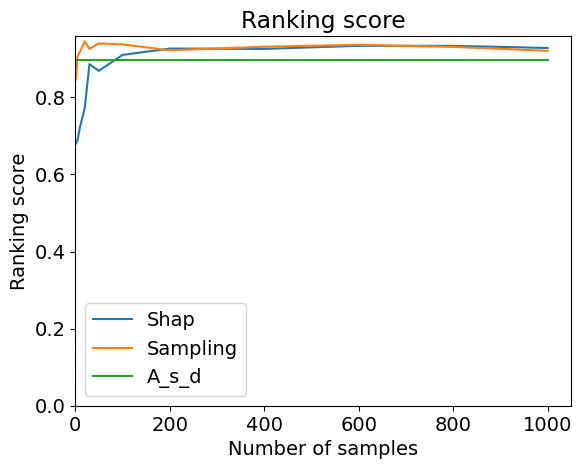

In [68]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure() 
plt.figure().clear()
plt.rcParams.update({'font.size': 14})
t = [i[0] for i in all_scores]
plt.plot(t,shap_scores,label='Shap')
plt.plot(t,mc_scores,label='Sampling')
plt.plot(t,asd_scores,label='A_s_d')
plt.title("Ranking score")
plt.xlabel("Number of samples")
plt.ylabel("Ranking score")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
plt.savefig("ranking_score.png")
plt.show()


In [22]:
shaps = maximum_likelihood_calculator_d_1.calculate_shapley_values(10)

1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10


In [23]:
shaps

[array([[0.  , 0.53, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]]),
 array([[ 0.335, -0.665,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
          0.   ,  0.   ]]),
 array([[ 0.       , -0.278125 ,  0.       ,  0.       , -0.1359375,
          0.       ,  0.       ,  0.       , -0.1528125,  0.366875 ]])]

In [24]:
ground_truth_shapleys


[array([-0.0407381 ,  0.12841865, -0.08768056]),
 array([ 0.38297222, -0.29733532, -0.0856369 ]),
 array([ 0.17461905, -0.08733532, -0.08728373]),
 array([ 0.38297222, -0.29733532, -0.0856369 ]),
 array([-0.0407381 ,  0.12841865, -0.08768056]),
 array([-0.05725595,  0.01377579,  0.04348016]),
 array([ 0.00443056,  0.0832004 , -0.08763095]),
 array([-0.086125 ,  0.0247877,  0.0613373]),
 array([ 0.01831944,  0.06931151, -0.08763095]),
 array([-0.19345635, -0.09590675,  0.2893631 ])]

In [58]:
calculate_score_of_ranking(list(range(12)),list(range(12)))

61.11288525800155

In [51]:
calculateRankingResultsForLabel(0, ground_truth_shapleys, shaps, maximum_likelihood_calculator_d_1.get_A_s_d_values(), shaps_real)

[(45.43559338088346, 43.804663627311996, 42.98713426200406)]

In [29]:
ground_truth_shapleys

[array([-0.0407381 ,  0.12841865, -0.08768056]),
 array([ 0.38297222, -0.29733532, -0.0856369 ]),
 array([ 0.17461905, -0.08733532, -0.08728373]),
 array([ 0.38297222, -0.29733532, -0.0856369 ]),
 array([-0.0407381 ,  0.12841865, -0.08768056]),
 array([-0.05725595,  0.01377579,  0.04348016]),
 array([ 0.00443056,  0.0832004 , -0.08763095]),
 array([-0.086125 ,  0.0247877,  0.0613373]),
 array([ 0.01831944,  0.06931151, -0.08763095]),
 array([-0.19345635, -0.09590675,  0.2893631 ])]

In [32]:
shaps[0]=[[i[0] for i in ground_truth_shapleys]]

[[[-0.04073809523809525,
   0.38297222222222227,
   0.17461904761904762,
   0.38297222222222227,
   -0.04073809523809525,
   -0.05725595238095239,
   0.0044305555555555565,
   -0.08612500000000001,
   0.018319444444444447,
   -0.19345634920634922]],
 array([[ 0.335, -0.665,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
          0.   ,  0.   ]]),
 array([[ 0.       , -0.278125 ,  0.       ,  0.       , -0.1359375,
          0.       ,  0.       ,  0.       , -0.1528125,  0.366875 ]])]

In [47]:
shaps_real = maximum_likelihood_calculator_d_1.calculate_shapley_values(2000)

1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1022
